In [1]:
import helper_functions as hf

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchinfo import summary

from pathlib import Path
import numpy as np

import random
import PIL
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import time

REBUILD_DATA = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get data

In [2]:
data_path = Path("path/to/data") # Change the path to the data folder here

In [3]:
hf.walk_through_dir(data_path)

There are 2 directories and 1 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data'.
There are 2 directories and 0 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\test'.
There are 0 directories and 2500 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\test\Cat'.
There are 0 directories and 2500 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\test\Dog'.
There are 2 directories and 0 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\train'.
There are 0 directories and 10000 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\train\Cat'.
There are 0 directories and 10000 images in 'C:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\Cats_Vs_Dogs\data\train\Dog'.


In [4]:
path_list = list(data_path.glob('*/*/*.jpg'))
len(path_list)

25000

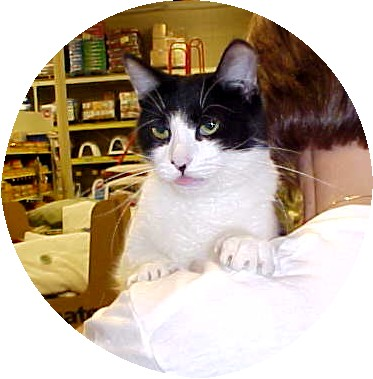

In [5]:
PIL.Image.open(random.choice(path_list))

# Preparing the data

In [6]:
COLOR_CHANNELS = 3
IMG_SIZE = 128

Image Normalization

The values of mean and standard deviation of the training set are [0.4883, 0.4553, 0.4170],[0.2229, 0.2182, 0.2185]

Run the below cell if you want to calculate the mean and standard deviation again.

In [7]:
# # Run this cell to calculate mean and deviation of color
# # Calculate mean and deviation of color
# data_tranformer = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor()
# ])

# train_dataset = datasets.ImageFolder(root=data_path / "train", transform=data_tranformer)
# test_dataset = datasets.ImageFolder(root=data_path / "test", transform=data_tranformer)
# complete_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# # Calculate mean image
# mean_color = torch.zeros(COLOR_CHANNELS)
# std_color = torch.zeros(COLOR_CHANNELS)

# for image, _ in tqdm(complete_dataset):
#     mean_color += image.mean(dim=(1,2)) # Mean of each channel
#     std_color += image.std(dim=(1,2)) # Std of each channel
    
# mean_color = mean_color / len(complete_dataset) # Mean of all images
# std_color = std_color / len(complete_dataset) # Std of all images

# print(f"Mean color: {mean_color}")
# print(f"Std color: {std_color}")

In [8]:
normalized_data_tranformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.4883, 0.4553, 0.4170],[0.2229, 0.2182, 0.2185]),
])

train_dataset = datasets.ImageFolder(root=data_path / "train",transform=normalized_data_tranformer)
test_dataset = datasets.ImageFolder(root=data_path / "test", transform=normalized_data_tranformer)

In [9]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 128, 128]), 0)

In [10]:
CLASSES = train_dataset.classes
CLASSES

['Cat', 'Dog']

After normalization pixel values are in the range of [-1, 1]. Hence the images have bad contrast.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128]) Dog


(-0.5, 127.5, 127.5, -0.5)

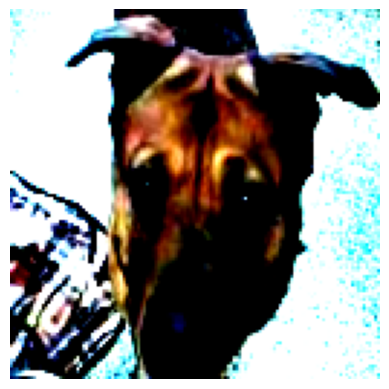

In [11]:
image, label = random.choice(train_dataset)
print(image.shape, CLASSES[label])
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.axis('off')

In [12]:
# Creat data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Creating Model

In [67]:
# Create model
class TinyVGG(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.BatchNorm2d(10)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.BatchNorm2d(10)
        )
        
        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2560, 2)
        )
                    
    def forward(self, x):
        return self.Classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))
    
    
class CatVsDog_2M(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.BatchNorm2d(256)
        )
        
        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            # nn.Softmax(dim=1)
        )
                    
    def forward(self, x):
        return self.Classifier(self.conv_block(x))

In [68]:
model = TinyVGG()
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 128, 128]         280
│    └─ReLU: 2-2                         [1, 10, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 10, 128, 128]         910
│    └─ReLU: 2-4                         [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 10, 64, 64]           --
│    └─BatchNorm2d: 2-6                  [1, 10, 64, 64]           20
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 10, 64, 64]           910
│    └─ReLU: 2-8                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 10, 64, 64]           910
│    └─ReLU: 2-10                        [1, 10, 64, 64]           --
│    └─MaxP

# Training Model

Overfitting to a single batch of data is good practice to check if the model is working properly.
If model can't overfit a single batch then there is something wrong with the model.

Run for about 10 epochs and final loss must be less than 0.1

In [69]:
# Overfit on a single batch
overfit_model = CatVsDog_2M().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
overfit_model_optimizer = torch.optim.Adam(overfit_model.parameters(), lr=0.0005)
final_loss = hf.overfit_single_batch(overfit_model, train_loader, loss_fn, overfit_model_optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

0.04725136235356331


Create the model

In [70]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [71]:
# Config
print("Using device:" + device)

EPOCHS = 10
test_every = 5

train_losses = []
train_accuracies = []

Using device:cuda


In [72]:
# Trigger training
train_losses, test_losses = hf.train_model(model, train_loader, test_loader, loss_fn, optimizer, device, EPOCHS, test_every=test_every)

---------------------EPOCH 1---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

c:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\.venv\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning:

Truncated File Read



	Train Loss: 0.6217, Train Acc: 66.6400%


---------------------EPOCH 2---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.5096, Train Acc: 75.1600%


---------------------EPOCH 3---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.4562, Train Acc: 78.5500%


---------------------EPOCH 4---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.4130, Train Acc: 81.1550%


---------------------EPOCH 5---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.3800, Train Acc: 82.9700%
Testing...

  0%|          | 0/157 [00:00<?, ?it/s]

	Test Loss: 0.4539, Test Acc: 79.7771%


---------------------EPOCH 6---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.3582, Train Acc: 84.2750%


---------------------EPOCH 7---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.3327, Train Acc: 85.4100%


---------------------EPOCH 8---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.3141, Train Acc: 86.2850%


---------------------EPOCH 9---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.2993, Train Acc: 86.9100%


---------------------EPOCH 10---------------------
Training...

  0%|          | 0/625 [00:00<?, ?it/s]

	Train Loss: 0.2777, Train Acc: 88.1550%
Testing...

  0%|          | 0/157 [00:00<?, ?it/s]

	Test Loss: 0.4341, Test Acc: 81.9268%




c:\Users\katti\Desktop\Python-Projects\Tuts_And_Projects\SOS\cats_vs_dogs\helper_functions.py:146: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



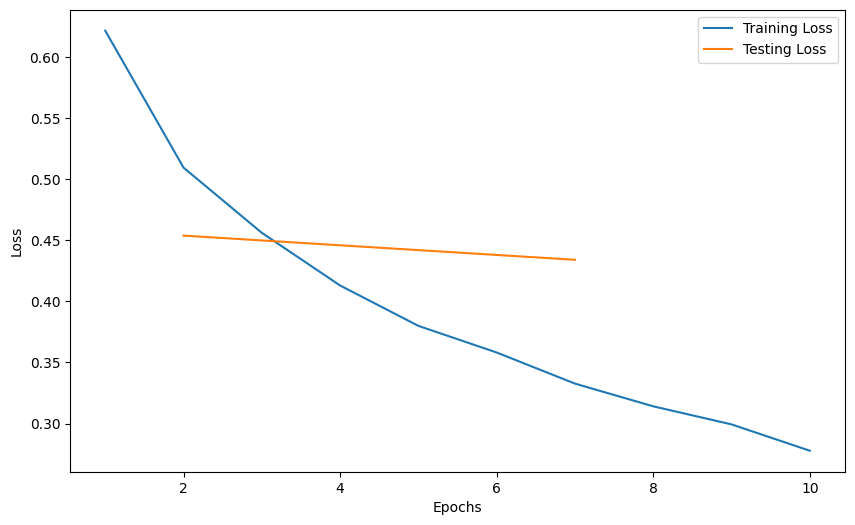

In [73]:
# Plot loss curve
hf.plot_loss_curve(train_losses, test_losses, every_n=test_every)

In [74]:
# Save model
torch.save(model.state_dict(), f"model_cats_vs_dogs_1M.pth")

In [22]:
# Load model
# model.load_state_dict(torch.load("model_cats_vs_dogs_1M.pth"))

# Testing Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


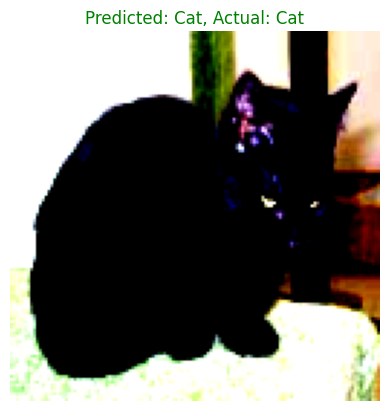

In [79]:
# Test Model
hf.show_random_prediction(model, test_dataset)

In [80]:
predictions = hf.predict(model, test_dataset, device)

Predicting...


  0%|          | 0/5000 [00:00<?, ?it/s]

In [81]:
hf.plot_metrics(test_dataset.targets, predictions, test_dataset.classes)

              precision    recall  f1-score   support

         Cat     0.8080    0.8384    0.8229      2500
         Dog     0.8321    0.8008    0.8161      2500

    accuracy                         0.8196      5000
   macro avg     0.8201    0.8196    0.8195      5000
weighted avg     0.8201    0.8196    0.8195      5000

